**Importing the required libraries**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

**Defining the model paths**

In [7]:
# For this task we will use a trained model(which is available publically)
v2_prototxt = "model/colorization_deploy_v2.prototxt"
caffemodel = "model/colorization_release_v2.caffemodel"
points = "model/pts_in_hull.npy"

**Providing the test image**

In [8]:
# We provide the path of our test image to the input_image variable
input_image = "input/dog.jpg"

**Loading the model and adding the cluster centre as 1*1 convolutions**

In [9]:
# We load the serialized black and white colorizer 
net = cv2.dnn.readNetFromCaffe(v2_prototxt,caffemodel)
points = np.load(points)
# Now we add the cluster centres to the model as 1*1 convolutions
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = points.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

**Loading the input image, converting it to LAB**

In [10]:
# We load the input image and convert it to gray scale just to clean them.
image = cv2.imread(input_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Next our image needs to be converted from rgb to Lab
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
# Before converting to Lab, we scale in order to extract the 'L' channel and centre it in future 
scaled = image.astype("float32") / 255.0
lab = cv2.cvtColor(scaled, cv2.COLOR_RGB2LAB)

**Display the test image given as input**

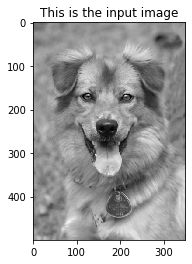

In [11]:
plt.imshow(image)
plt.axis('on');
plt.title('This is the input image');

**Displaying the image converted to Lab format**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


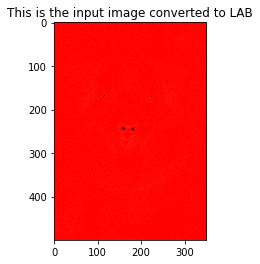

In [12]:
plt.imshow(lab)
plt.axis('on');
plt.title('This is the input image converted to LAB');

**Extracting the 'L' component from the Lab image**

In [13]:
resized_image = cv2.resize(lab, (224, 224))
L_channel = cv2.split(resized_image)[0]
L_channel -= 50

**Predicting the 'a' and 'b' components**

In [14]:
net.setInput(cv2.dnn.blobFromImage(L_channel))
a_and_b = net.forward()[0, :, :, :].transpose((1, 2, 0))
ab = cv2.resize(a_and_b, (image.shape[1], image.shape[0]))
L = cv2.split(lab)[0]
# After getting the predicted values of 'a' and 'b' we combine the L+a+b
LAB_colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

**Displaying the Lab image**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


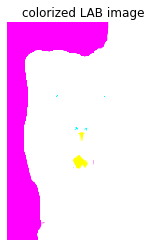

In [15]:
# We display the Lab image which we have got after concatenating the predict 'a' and 'b' components to the 'L' component
plt.imshow(LAB_colorized)
plt.axis('off');
plt.title('colorized LAB image');

In [16]:
# For better visualisation we covert our Lab image to rgb image
lab_to_rgb_colorized = cv2.cvtColor(LAB_colorized, cv2.COLOR_LAB2RGB)
clipped_colorized = np.clip(lab_to_rgb_colorized, 0, 1)
colorized = (255 * clipped_colorized).astype("uint8")

**Displaying the input vs output image**

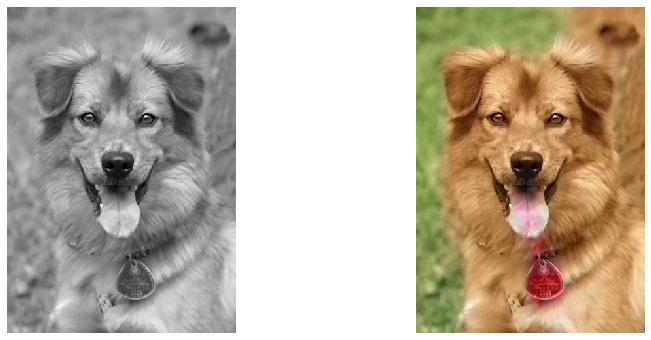

In [17]:
plt.figure(1, figsize=(14,6))
plt.subplots_adjust(wspace=0.1)
plt.subplot(121)
plt.axis('off');
plt.imshow(image);

plt.subplot(122)
plt.axis('off');
plt.imshow(colorized);